In [1]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # act_funtion = F.sigmoid oder F.relu
        x = self.act_function(self.lin1(x))
        x = self.act_function(self.lin2(x))
        x = self.lin3(x)
        return x

In [4]:
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [5]:
def make_data(dataset, features, batch_size, debug=False):
    datasets = []
    for file in dataset:
        datasets.append(pd.read_csv("../" + file))
    dataset = pd.concat(datasets, axis=0, ignore_index=True)
    
    target = dataset["affect"]
    dataset_full = dataset[["word_count", "upper_word_count", "ent_word_count", "h_count", "s_count", "a_count", "f_count", "cons_punct_count"]]
    dataset_nolex = dataset[["word_count", "upper_word_count", "ent_word_count", "cons_punct_count"]]
    dataset_lex = dataset[["h_count", "s_count", "a_count", "f_count"]]
    
    # make train and test sets
    if features == "full": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.2)
    elif features == "nolex":
        train_x, test_x, train_y, test_y = train_test_split(dataset_nolex, target, test_size=0.2)
    elif features == "lex": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_lex, target, test_size=0.2)

    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    if debug: 
        dataset_full = dataset_full.iloc[:10]
        target = target[:10]
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.8)
        train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
        test_loader = DataLoader(dataset=train_data, batch_size=1)
    return train_loader, test_loader 

In [6]:
def log(summary, file):
    log = open(file, "a")
    log.write(summary)
    log.close()
    print(summary)

In [7]:
def train(train_loader, net, epochs, criterion, print_every, save_name, cuda, lr):
    open(save_name + "_train", "w").close()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    error_curve = []
    net.train()
    for epoch in range(epochs):
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.float()
            if cuda: 
                inputs = inputs.cuda()
                targets = targets.cuda()
                net = net.cuda()
            pred = net(inputs)    
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ((index) % print_every == 0):
                log("batch: {}/{} in epoch {}/{} \n... loss: {}\n".
                    format((index+1), len(train_loader), (epoch+1), epochs, loss.item()), 
                    save_name + "_train")
        # save network after every epoch
        torch.save(net.state_dict(), save_name + ".pt")  
        # after every epoch save the error
        error_curve.append([epoch, loss.item()])
    log("\n" + str(error_curve), save_name + "_train")
    plot = plt.plot([item[0] for item in error_curve], [item[1] for item in error_curve])
    plt.savefig(save_name+"_train_error.png")

def test(test_loader, net, criterion, print_every, save_name, cuda):
    open(save_name + "_test", "w").close()
    confusion = []
    net.eval()
    loss_sum, correct, correct2 = 0, 0, 0
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.float(), targets.float()
        if cuda: 
            inputs = inputs.cuda()
            targets = targets.cuda()
            net = net.cuda()
        pred = net(inputs)
        pred_class = round(pred.item())
        loss_sum += criterion(pred, targets).item()
        confusion.append([targets.item(), pred_class])
        
        # correct? 
        if pred_class == targets.item():
            correct += 1
        
        if ((index) % print_every == 0):
            log("batch: {}/{}\n... correct: {}\n".
                format((index+1), len(test_loader), correct), 
                save_name + "_test")
           
    # give end report
    log("average test loss: {}, relative correct: {}\n\nconfusion:\n{}".
        format((loss_sum / len(test_loader)), (correct / len(test_loader)),str(confusion)), 
        save_name + "_test")

In [8]:
# create variables 
print("creating variables")
emotion_dataset = ["emotion_classification_1_clean.csv", "emotion_classification_2_clean.csv", "emotion_classification_3_clean.csv", "emotion_classification_4_clean.csv", "emotion_classification_5_clean.csv", "emotion_classification_6_clean.csv", "emotion_classification_7_clean.csv", "emotion_classification_8_clean.csv"]
tweet_dataset = ["crowdflower_clean.csv", "emoint_clean.csv", "tec_clean.csv"]
act_function = torch.sigmoid
criterion = nn.MSELoss()
cuda = torch.cuda.is_available()
batch_size = 25

creating variables


/home/marcel/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch: 1/1 in epoch 1/1000 
... loss: 1.7329624891281128

batch: 1/1 in epoch 2/1000 
... loss: 11.440106391906738

batch: 1/1 in epoch 3/1000 
... loss: 23.923999786376953

batch: 1/1 in epoch 4/1000 
... loss: 0.004358451813459396

batch: 1/1 in epoch 5/1000 
... loss: 0.31588196754455566

batch: 1/1 in epoch 6/1000 
... loss: 0.26433297991752625

batch: 1/1 in epoch 7/1000 
... loss: 0.10749535262584686

batch: 1/1 in epoch 8/1000 
... loss: 0.024315308779478073

batch: 1/1 in epoch 9/1000 
... loss: 0.003967489115893841

batch: 1/1 in epoch 10/1000 
... loss: 0.005499375984072685

batch: 1/1 in epoch 11/1000 
... loss: 0.007741155102849007

batch: 1/1 in epoch 12/1000 
... loss: 0.0068835108540952206

batch: 1/1 in epoch 13/1000 
... loss: 0.0049796630628407

batch: 1/1 in epoch 14/1000 
... loss: 0.0036837956868112087

batch: 1/1 in epoch 15/1000 
... loss: 0.003202561056241393

batch: 1/1 in epoch 16/1000 
... loss: 0.0031308613251894712

batch: 1/1 in epoch 17/1000 
... loss: 0.

batch: 1/1 in epoch 159/1000 
... loss: 0.001028376747854054

batch: 1/1 in epoch 160/1000 
... loss: 0.0010216583032160997

batch: 1/1 in epoch 161/1000 
... loss: 0.0010149847948923707

batch: 1/1 in epoch 162/1000 
... loss: 0.001008361461572349

batch: 1/1 in epoch 163/1000 
... loss: 0.0010017863241955638

batch: 1/1 in epoch 164/1000 
... loss: 0.0009952514665201306

batch: 1/1 in epoch 165/1000 
... loss: 0.0009887679480016232

batch: 1/1 in epoch 166/1000 
... loss: 0.0009823262225836515

batch: 1/1 in epoch 167/1000 
... loss: 0.0009759241947904229

batch: 1/1 in epoch 168/1000 
... loss: 0.0009695764747448266

batch: 1/1 in epoch 169/1000 
... loss: 0.0009632605942897499

batch: 1/1 in epoch 170/1000 
... loss: 0.0009569949470460415

batch: 1/1 in epoch 171/1000 
... loss: 0.0009507680661045015

batch: 1/1 in epoch 172/1000 
... loss: 0.000944579835049808

batch: 1/1 in epoch 173/1000 
... loss: 0.0009384391596540809

batch: 1/1 in epoch 174/1000 
... loss: 0.0009323367848992

batch: 1/1 in epoch 310/1000 
... loss: 0.00036800047382712364

batch: 1/1 in epoch 311/1000 
... loss: 0.0003654425381682813

batch: 1/1 in epoch 312/1000 
... loss: 0.0003629026177804917

batch: 1/1 in epoch 313/1000 
... loss: 0.0003603862423915416

batch: 1/1 in epoch 314/1000 
... loss: 0.0003578831674531102

batch: 1/1 in epoch 315/1000 
... loss: 0.00035540226963348687

batch: 1/1 in epoch 316/1000 
... loss: 0.000352941220626235

batch: 1/1 in epoch 317/1000 
... loss: 0.00035049987491220236

batch: 1/1 in epoch 318/1000 
... loss: 0.0003480758750811219

batch: 1/1 in epoch 319/1000 
... loss: 0.00034567140392027795

batch: 1/1 in epoch 320/1000 
... loss: 0.000343284074915573

batch: 1/1 in epoch 321/1000 
... loss: 0.0003409171476960182

batch: 1/1 in epoch 322/1000 
... loss: 0.00033856937079690397

batch: 1/1 in epoch 323/1000 
... loss: 0.0003362373390700668

batch: 1/1 in epoch 324/1000 
... loss: 0.00033392643672414124

batch: 1/1 in epoch 325/1000 
... loss: 0.000331632

batch: 1/1 in epoch 462/1000 
... loss: 0.0001402420166414231

batch: 1/1 in epoch 463/1000 
... loss: 0.0001394497521687299

batch: 1/1 in epoch 464/1000 
... loss: 0.00013866534573026001

batch: 1/1 in epoch 465/1000 
... loss: 0.00013788454816676676

batch: 1/1 in epoch 466/1000 
... loss: 0.00013711083738598973

batch: 1/1 in epoch 467/1000 
... loss: 0.0001363421033602208

batch: 1/1 in epoch 468/1000 
... loss: 0.0001355776039417833

batch: 1/1 in epoch 469/1000 
... loss: 0.0001348207879345864

batch: 1/1 in epoch 470/1000 
... loss: 0.0001340674643870443

batch: 1/1 in epoch 471/1000 
... loss: 0.00013331901573110372

batch: 1/1 in epoch 472/1000 
... loss: 0.00013257678074296564

batch: 1/1 in epoch 473/1000 
... loss: 0.00013184003182686865

batch: 1/1 in epoch 474/1000 
... loss: 0.00013110738655086607

batch: 1/1 in epoch 475/1000 
... loss: 0.0001303829048993066

batch: 1/1 in epoch 476/1000 
... loss: 0.0001296597474720329

batch: 1/1 in epoch 477/1000 
... loss: 0.000128

batch: 1/1 in epoch 614/1000 
... loss: 6.436138937715441e-05

batch: 1/1 in epoch 615/1000 
... loss: 6.406144530046731e-05

batch: 1/1 in epoch 616/1000 
... loss: 6.376314559020102e-05

batch: 1/1 in epoch 617/1000 
... loss: 6.346649752231315e-05

batch: 1/1 in epoch 618/1000 
... loss: 6.317054067039862e-05

batch: 1/1 in epoch 619/1000 
... loss: 6.287716678343713e-05

batch: 1/1 in epoch 620/1000 
... loss: 6.258588837226853e-05

batch: 1/1 in epoch 621/1000 
... loss: 6.229528662515804e-05

batch: 1/1 in epoch 622/1000 
... loss: 6.200582720339298e-05

batch: 1/1 in epoch 623/1000 
... loss: 6.171985296532512e-05

batch: 1/1 in epoch 624/1000 
... loss: 6.143360951682553e-05

batch: 1/1 in epoch 625/1000 
... loss: 6.115082214819267e-05

batch: 1/1 in epoch 626/1000 
... loss: 6.086776193114929e-05

batch: 1/1 in epoch 627/1000 
... loss: 6.0588139604078606e-05

batch: 1/1 in epoch 628/1000 
... loss: 6.030823351466097e-05

batch: 1/1 in epoch 629/1000 
... loss: 6.003082671668

batch: 1/1 in epoch 775/1000 
... loss: 3.1871895771473646e-05

batch: 1/1 in epoch 776/1000 
... loss: 3.174079392920248e-05

batch: 1/1 in epoch 777/1000 
... loss: 3.161130371154286e-05

batch: 1/1 in epoch 778/1000 
... loss: 3.14817443722859e-05

batch: 1/1 in epoch 779/1000 
... loss: 3.135311999358237e-05

batch: 1/1 in epoch 780/1000 
... loss: 3.12244264932815e-05

batch: 1/1 in epoch 781/1000 
... loss: 3.109666067757644e-05

batch: 1/1 in epoch 782/1000 
... loss: 3.096915679634549e-05

batch: 1/1 in epoch 783/1000 
... loss: 3.084390118601732e-05

batch: 1/1 in epoch 784/1000 
... loss: 3.0717579647898674e-05

batch: 1/1 in epoch 785/1000 
... loss: 3.059184382436797e-05

batch: 1/1 in epoch 786/1000 
... loss: 3.0467354008578695e-05

batch: 1/1 in epoch 787/1000 
... loss: 3.0344102924573235e-05

batch: 1/1 in epoch 788/1000 
... loss: 3.022012060682755e-05

batch: 1/1 in epoch 789/1000 
... loss: 3.009671672771219e-05

batch: 1/1 in epoch 790/1000 
... loss: 2.99748717225

batch: 1/1 in epoch 925/1000 
... loss: 1.7631879018153995e-05

batch: 1/1 in epoch 926/1000 
... loss: 1.7564867448527366e-05

batch: 1/1 in epoch 927/1000 
... loss: 1.7497983208158985e-05

batch: 1/1 in epoch 928/1000 
... loss: 1.743247230479028e-05

batch: 1/1 in epoch 929/1000 
... loss: 1.7365591702400707e-05

batch: 1/1 in epoch 930/1000 
... loss: 1.7299584214924835e-05

batch: 1/1 in epoch 931/1000 
... loss: 1.7234198821824975e-05

batch: 1/1 in epoch 932/1000 
... loss: 1.7168935301015154e-05

batch: 1/1 in epoch 933/1000 
... loss: 1.7103795471484773e-05

batch: 1/1 in epoch 934/1000 
... loss: 1.7038781152223237e-05

batch: 1/1 in epoch 935/1000 
... loss: 1.6974379832390696e-05

batch: 1/1 in epoch 936/1000 
... loss: 1.6910100384848192e-05

batch: 1/1 in epoch 937/1000 
... loss: 1.6846188373165205e-05

batch: 1/1 in epoch 938/1000 
... loss: 1.6782398233772255e-05

batch: 1/1 in epoch 939/1000 
... loss: 1.671848258411046e-05

batch: 1/1 in epoch 940/1000 
... loss: 1.

/home/marcel/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch: 1/2
... correct: 1

average test loss: 1.3255248177301837e-05, relative correct: 1.0

confusion:
[[1.0, 1], [1.0, 1]]
... done


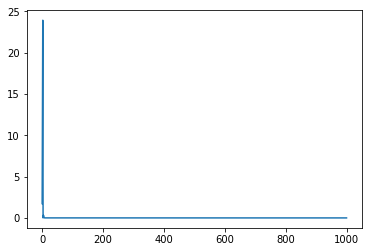

In [10]:
# debug set
net_full = Lin_Net(8, 1, 64, act_function)
train_loader_debug, test_loader_debug = make_data(emotion_dataset, "full", batch_size, True)
train(train_loader_debug, net_full, 1000, criterion, 100, "../logs/mse_debug", cuda, 0.1)
test(test_loader_debug, net_full, criterion, 100, "../logs/mse_debug", cuda)

print("... done")

In [8]:
print("-------- net_lin_emotion_full")
net_full = Lin_Net(8, 1, 64, act_function)
train_loader_emotion_full, test_loader_emotion_full = make_data(emotion_dataset, "full", batch_size)
train(train_loader_emotion_full, net_full, 100, criterion, 5000, "../logs/mse_emotion_full", cuda, 0.1)
test(test_loader_emotion_full, net_full, criterion, 1000, "../logs/mse_emotion_full")

print("-------- net_lin_emotion_nolex")
net_half = Lin_Net(4, 1, 64, act_function)
train_loader_emotion_nolex, test_loader_emotion_nolex = make_data(emotion_dataset, "nolex", batch_size)
train(train_loader_emotion_nolex, net_half, 100, criterion, 5000, "../logs/mse_emotion_nolex", cuda, 0.1)
test(test_loader_emotion_nolex, net_half, criterion, 1000, "../logs/mse_emotion_nolex")

print("-------- net_lin_emotion_lex")
net_half = Lin_Net(4, 1, 64, act_function)
train_loader_emotion_lex, test_loader_emotion_lex = make_data(emotion_dataset, "lex", batch_size)
train(train_loader_emotion_lex, net_half, 100, criterion, 5000, "../logs/mse_emotion_lex", cuda, 0.1)
test(test_loader_emotion_lex, net_half, criterion, 1000, "../logs/mse_emotion_lex")

print("-------- net_lin_tweet_full")
net_full = Lin_Net(8, 1, 64, act_function)
train_loader_tweet_full, test_loader_tweet_full = make_data(tweet_dataset, "full", batch_size)
train(train_loader_tweet_full, net_full, 100, criterion, 5000, "../logs/mse_tweet_full", cuda, 0.1)
test(test_loader_tweet_full, net_full, criterion, 1000, "../logs/mse_tweet_full")

print("-------- net_lin_tweet_nolex")
net_half = Lin_Net(4, 1, 64, act_function)
train_loader_tweet_nolex, test_loader_tweet_nolex = make_data(tweet_dataset, "nolex", batch_size)
train(train_loader_tweet_nolex, net_half, 100, criterion, 5000, "../logs/mse_tweet_nolex", cuda, 0.1)
test(test_loader_tweet_nolex, net_half, criterion, 1000, "../logs/mse_tweet_nolex")

print("-------- net_lin_tweet_lex")
net_half = Lin_Net(4, 1, 64, act_function)
train_loader_tweet_lex, test_loader_tweet_lex = make_data(tweet_dataset, "lex", batch_size)
train(train_loader_tweet_lex, net_half, 100, criterion, 5000, "../logs/mse_tweet_lex", cuda, 0.1)
test(test_loader_tweet_lex, net_half, criterion, 1000, "../logs/mse_tweet_lex")

print("... done")